# Metrics

# Loading libraries

In [29]:
%pip install datasets nltk spacy wordfreq language-tool-python textstat cffi

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\user\appdata\local\programs\python\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [1]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 3.4 MB/s eta 0:00:04
     ---- ----------------------------------- 1.6/12.8 MB 4.4 MB/s eta 0:00:03
     ---------- ----------------------------- 3.4/12.8 MB 5.9 MB/s eta 0:00:02
     ---------------- ----------------------- 5.2/12.8 MB 6.8 MB/s eta 0:00:02
     --------------------- ------------------ 6.8/12.8 MB 7.1 MB/s eta 0:00:01
     ---------------------------- ----------- 9.2/12.8 MB 7.6 MB/s eta 0:00:01
     -------------------------------- ------- 10.5/12.8 MB 7.3 MB/s eta 0:00:01
     -------------------------------------- - 12.3/12.8 MB 7.6 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 7.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [2]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nickolaus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nickolaus\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nickolaus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from nltk.corpus import wordnet as wn

In [5]:
!pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

In [5]:
from collections import Counter

# Loading DS

In [6]:
LANGUAGE = 'en'
LANGUAGE_FULL = 'english'

In [7]:
from datasets import load_dataset, load_from_disk

# dataset = load_dataset('BAAI/Infinity-Instruct', '3M', split='train[:1%]')
dataset = load_from_disk("infinity_instruct")

dataset = dataset.filter(lambda record: record["langdetect"] == "en")

print(dataset[0])

c:\Users\Nickolaus\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Filter: 100%|██████████| 34635/34635 [00:01<00:00, 20488.63 examples/s]

{'id': 0, 'conversations': [{'from': 'human', 'value': 'Write a PHP program to flatten a multi-dimensional array, but without using any built-in functions or methods for flattening arrays. Additionally, ensure that the program can handle arrays with a depth of up to 10 levels.'}, {'from': 'gpt', 'value': "Here's a PHP program to flatten a multi-dimensional array without using any built-in functions or methods for flattening arrays:\n\n```php\n<?php\n\nfunction flattenArray($arr) {\n    $result = [];\n    \n    foreach ($arr as $value) {\n        if (is_array($value)) {\n            $nestedArray = flattenArray($value);\n            foreach ($nestedArray as $nestedValue) {\n                $result[] = $nestedValue;\n            }\n        } else {\n            $result[] = $value;\n        }\n    }\n    \n    return $result;\n}\n\n// Test the function\n$multiDimensionalArray = [1, 2, [3, 4, [5, 6, [7, 8, [9, 10]]]]];\n$flattenedArray = flattenArray($multiDimensionalArray);\n\nprint_r($fla

In [8]:
dataset.save_to_disk("infinity_instruct_en")
print("Saved locally")

Saving the dataset (1/1 shards): 100%|██████████| 27209/27209 [00:00<00:00, 71026.81 examples/s]

Saved locally


# Preprocessing

In [9]:
texts = []
for item in tqdm(dataset, desc="Processing dataset"):
    for conv in item['conversations']:
        if conv['from'] == 'human':
            texts.append(conv['value'])

Processing dataset: 100%|██████████| 27209/27209 [00:04<00:00, 6683.89it/s]


In [10]:
print(len(texts))

39564


In [11]:
texts[0]

'Write a PHP program to flatten a multi-dimensional array, but without using any built-in functions or methods for flattening arrays. Additionally, ensure that the program can handle arrays with a depth of up to 10 levels.'

In [12]:
full_text = "\n".join(texts)

# Computing

In [14]:
metrics_res = {}
times_res = []

## Lexical

### Word-frequency list

In [15]:
from wordfreq import word_frequency

words = full_text.split()
word_counts = Counter(words)

zipf_scores = {word: word_frequency(word, LANGUAGE) for word in word_counts}
print(word_counts.most_common(10))

[('the', 142199), ('to', 68537), ('and', 68122), ('a', 67442), ('of', 67026), ('in', 39375), ('is', 35457), ('for', 27484), ('that', 24482), ('with', 17758)]


In [16]:
from math import log


def compute_difficulty_freq(text):
    words = text.split()
    score = 0
    for word in words:
        word_freq = zipf_scores[word]
        score += (1 / word_freq) if word_freq > 0 else 0
    score /= len(words)
    return log(score) if score != 0 else 0

metrics_res['word_frequency'] = [compute_difficulty_freq(text) for text in tqdm(texts, desc="Computing difficulty")]

Computing difficulty: 100%|██████████| 39564/39564 [00:00<00:00, 40445.89it/s]


39564


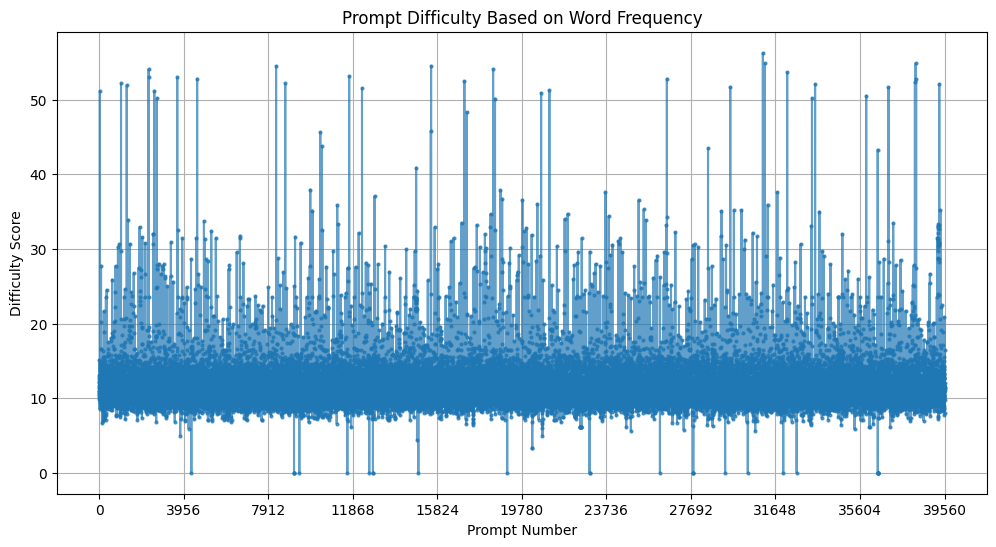

In [17]:
scores = [(index, score) for index, score in enumerate(metrics_res['word_frequency'])]
# indicies, scores = zip(*scores) if scores else ([], [])
print(len(scores))

plt.figure(figsize=(12, 6))
plt.plot(range(len(scores)), metrics_res['word_frequency'], marker='o', linestyle='-', markersize=2, alpha=0.7)
plt.xlabel("Prompt Number")
plt.ylabel("Difficulty Score")
plt.title("Prompt Difficulty Based on Word Frequency")
plt.xticks(np.arange(0, len(scores), step=max(1, len(scores)//10)))
plt.grid(True)

plt.show()

In [18]:
def print_most_difficult(scores, reverse=True, filtered=False):
    most_difficult = (sorted(scores, key=lambda x : x[1], reverse=reverse))
    if filtered:
        most_difficult = list(filter(lambda x : x[1] > 0, most_difficult))
        
    most_difficult = most_difficult[:5]
    for diff in most_difficult:
        print(diff[0], end=" ")
    print()

    for idx, diff in enumerate(most_difficult):
        print("---", idx + 1, "example (", diff[1], "):")
        print(texts[diff[0]])
        print("------\n")

In [47]:
print_most_difficult(scores)

31057 31137 38203 15532 8279 
--- 1 example ( 56.294955215025226 ):
Please focus on the algorithm of this problem and provide code in Haskell:
Given an integer `n` represented as a string, return _the smallest **good base** of_ `n`.

We call `k >= 2` a **good base** of `n`, if all digits of `n` base `k` are `1`'s.

**Example 1:**

**Input:** n =  "13 "
**Output:**  "3 "
**Explanation:** 13 base 3 is 111.

**Example 2:**

**Input:** n =  "4681 "
**Output:**  "8 "
**Explanation:** 4681 base 8 is 11111.

**Example 3:**

**Input:** n =  "1000000000000000000 "
**Output:**  "999999999999999999 "
**Explanation:** 1000000000000000000 base 999999999999999999 is 11.

**Constraints:**

*   `n` is an integer in the range `[3, 1018]`.
*   `n` does not contain any leading zeros.
------

--- 2 example ( 54.860451285297536 ):
66 cubic centimetres of silver is drawn into a wire of certain diameter. The length of the wire in meters is 84.03380995252074. What is the diameter of the wire in mm?
------

--

### Identify stop words

In [51]:
from nltk.corpus import stopwords
from math import log

stop_words = set(stopwords.words(LANGUAGE_FULL))

def compute_difficulty_stopwords(text):
    words = text.split()
    score = 0
    for word in words:
        if word.lower() in stop_words:
            continue
        
        word_freq = zipf_scores.get(word, 0)
        score += 1 / (word_freq if word_freq > 0 else 1e-6)
    return log(score) if score != 0 else 0

metrics_res['stopwords'] = [
    compute_difficulty_stopwords(text) for text in tqdm(texts, desc="Computing difficulty (no stop-words)")
]


Computing difficulty (no stop-words):   0%|          | 0/39564 [00:00<?, ?it/s]

Computing difficulty (no stop-words): 100%|██████████| 39564/39564 [00:00<00:00, 43074.64it/s]


Total prompts: 39564


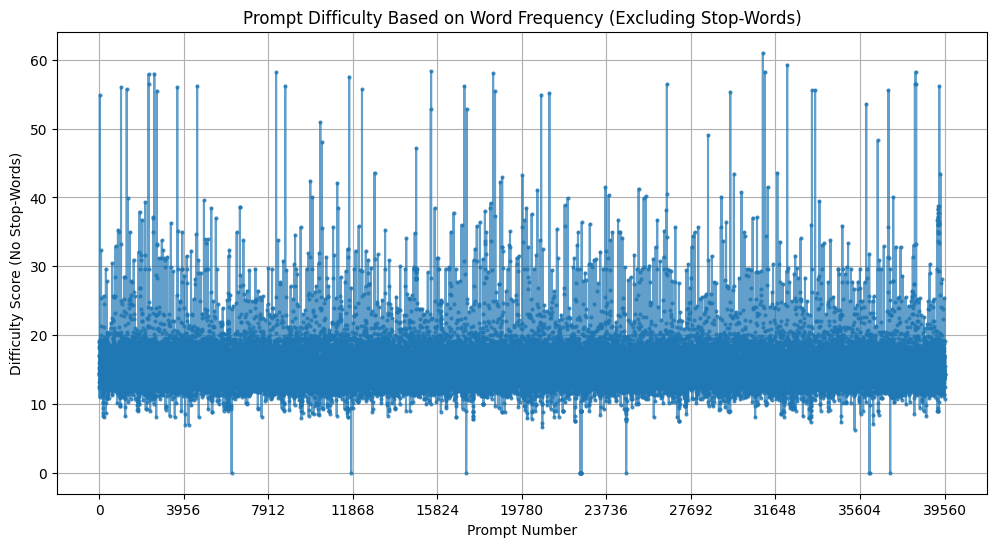

In [52]:
scores = [(index, score) for index, score in enumerate(metrics_res['stopwords'])]
print(f"Total prompts: {len(scores)}")

print_scores = [i[1] for i in scores]

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(scores)), print_scores, marker='o', linestyle='-', markersize=2, alpha=0.7)
plt.xlabel("Prompt Number")
plt.ylabel("Difficulty Score (No Stop-Words)")
plt.title("Prompt Difficulty Based on Word Frequency (Excluding Stop-Words)")
plt.xticks(np.arange(0, len(scores), step=max(1, len(scores)//10)))
plt.grid(True)
plt.show()

In [53]:
print_most_difficult(scores)

31057 32196 15532 31137 38203 
--- 1 example ( 61.031153663419715 ):
Please focus on the algorithm of this problem and provide code in Haskell:
Given an integer `n` represented as a string, return _the smallest **good base** of_ `n`.

We call `k >= 2` a **good base** of `n`, if all digits of `n` base `k` are `1`'s.

**Example 1:**

**Input:** n =  "13 "
**Output:**  "3 "
**Explanation:** 13 base 3 is 111.

**Example 2:**

**Input:** n =  "4681 "
**Output:**  "8 "
**Explanation:** 4681 base 8 is 11111.

**Example 3:**

**Input:** n =  "1000000000000000000 "
**Output:**  "999999999999999999 "
**Explanation:** 1000000000000000000 base 999999999999999999 is 11.

**Constraints:**

*   `n` is an integer in the range `[3, 1018]`.
*   `n` does not contain any leading zeros.
------

--- 2 example ( 59.308839638887456 ):
##1801##C: Canisal cryptography

problem

Ebi-chan was given the string C obtained by encrypting a non-negative integer D with "canisal cipher". This cipher replaces each number

## Syntactic

### Number of clauses

In [21]:
def count_clauses(text):
    doc = nlp(text)
    clause_count = 0
    sentence_count = len(list(doc.sents))
    
    for token in doc:
        if token.dep_ in {"ROOT", "ccomp", "advcl", "acl", "relcl"}:
            clause_count += 1

    return clause_count / sentence_count if sentence_count > 0 else 0


metrics_res['clauses'] = [
    count_clauses(text) for text in tqdm(texts, desc="Computing difficulty (clauses)")
]

Computing difficulty (clauses): 100%|██████████| 39564/39564 [17:18<00:00, 38.10it/s]  


Total prompts: 39564


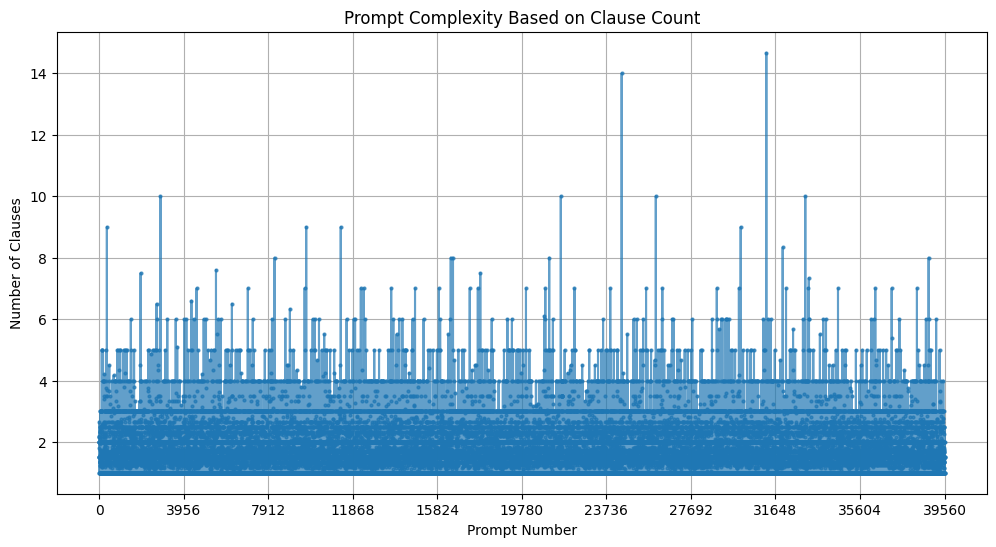

In [48]:
scores = [(index, score) for index, score in enumerate(metrics_res['clauses'])]
print(f"Total prompts: {len(scores)}")

print_scores = [i[1] for i in scores]

plt.figure(figsize=(12, 6))
plt.plot(range(len(scores)), print_scores, marker='o', linestyle='-', markersize=2, alpha=0.7)
plt.xlabel("Prompt Number")
plt.ylabel("Number of Clauses")
plt.title("Prompt Complexity Based on Clause Count")
plt.xticks(np.arange(0, len(scores), step=max(1, len(scores)//10)))
plt.grid(True)
plt.show()

In [49]:
print_most_difficult(scores)

31220 24449 2868 
--- 1 example ( 14.666666666666666 ):
Write really overly-funny super hilarious comedy 17+ short Scooby-Doo cartoon parody transcript that always starts with the villain moment first, then the gang hearing about it once they reach the area, and then the rest based on my prompt: (but make it more funnier adult comedy where the gang constantly make fun of and question physics that ain’t possible or don’t make any sense and why, they always mistake some character for a famous person because of their surname being literally the same as a real life celebrity, forcing the character to correct them angrily, Shaggy is often the one who would mishear a location name, leading to someone correcting him angrily and why, Velma is often rudely interrupted by the gang insulting her when she says something too scientifically smart,  they always know that a place they are going to doesn't sound like it exists, they also know something in a place they go to shouldn't even be there as i

### Dependency tree

In [22]:
def compute_tree_depth_for_sent(sent):
    roots = [token for token in sent if token.head == token]
    if not roots:
        return 0
    root = roots[0]
    
    def depth(token):
        if not list(token.children):
            return 1
        return 1 + max(depth(child) for child in token.children)
    
    return depth(root)


def compute_syntactic_complexity(text):
    doc = nlp(text)
    sentence_depths = []
    for sent in doc.sents:
        sent_depth = compute_tree_depth_for_sent(sent)
        sentence_depths.append(sent_depth)
    if sentence_depths:
        return np.mean(sentence_depths)
    return 0


metrics_res['syntactic_complexity'] = [
    compute_syntactic_complexity(text) for text in tqdm(texts, desc="Computing syntactic complexity")
]

Computing syntactic complexity:   0%|          | 0/39564 [00:00<?, ?it/s]

Computing syntactic complexity: 100%|██████████| 39564/39564 [23:39<00:00, 27.87it/s]  


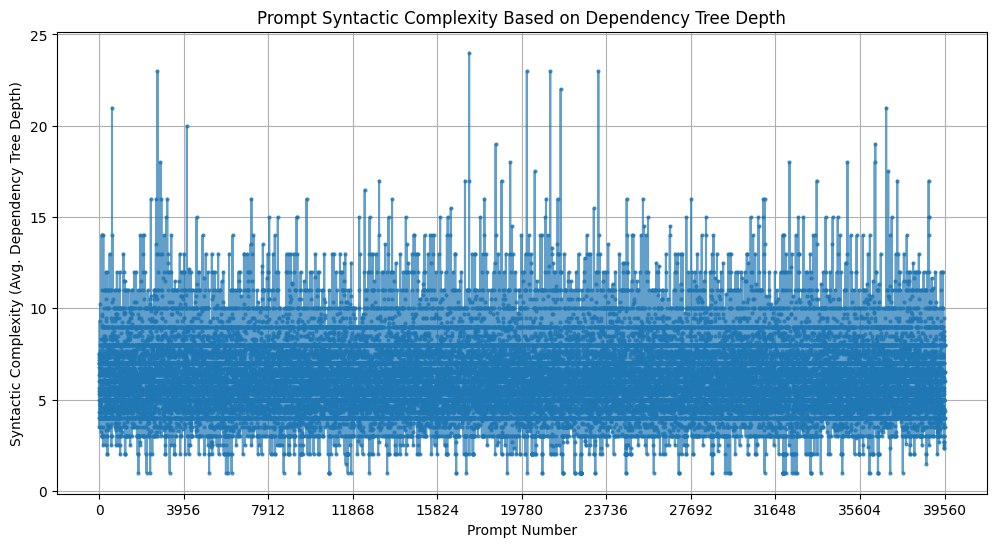

In [51]:
scores = [(index, score) for index, score in enumerate(metrics_res['syntactic_complexity'])]

plt.figure(figsize=(12, 6))
plt.plot(
    range(len(scores)),
    [score for _, score in scores],
    marker='o',
    linestyle='-',
    markersize=2,
    alpha=0.7
)
plt.xlabel("Prompt Number")
plt.ylabel("Syntactic Complexity (Avg. Dependency Tree Depth)")
plt.title("Prompt Syntactic Complexity Based on Dependency Tree Depth")
plt.xticks(np.arange(0, len(scores), step=max(1, len(scores)//10)))
plt.grid(True)
plt.show()

In [52]:
print_most_difficult(scores)

17311 2727 20012 
--- 1 example ( 24.0 ):
Please answer the following question: "Ronald Plasterk", given a list of categories: company, educational institution, artist, athlete, office holder, mean of transportation, building, natural place, village, animal, plant, album, film or written work, what category does the title belong to?
A:
------

--- 2 example ( 23.0 ):
Answer the following question: "Billy Snedden", given a list of categories: company, educational institution, artist, athlete, office holder, mean of transportation, building, natural place, village, animal, plant, album, film or written work, what category does the title belong to?
Answer:
------

--- 3 example ( 23.0 ):
"Obsza", given a list of categories: company, educational institution, artist, athlete, office holder, mean of transportation, building, natural place, village, animal, plant, album, film or written work, what category does the title belong to?
Answer:
------



### Words number and length

In [19]:
metrics_res['words_number'] = [
    len(text) for text in tqdm(texts, desc="Computing words length")
]

Computing words length: 100%|██████████| 39564/39564 [00:00<00:00, 1978201.89it/s]


Total prompts: 39564


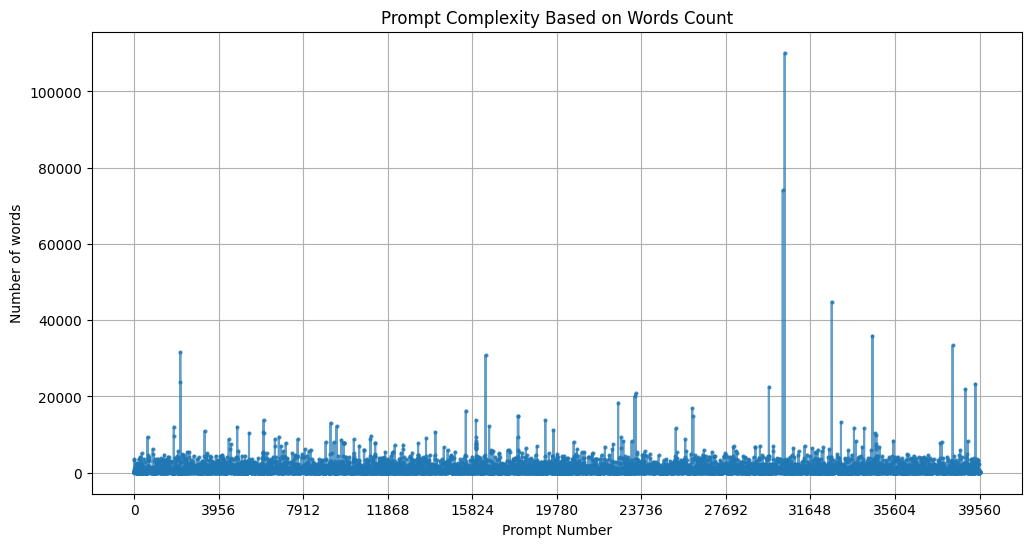

In [20]:
scores = [(index, score) for index, score in enumerate(metrics_res['words_number'])]
print(f"Total prompts: {len(scores)}")

print_scores = [i[1] for i in scores]

plt.figure(figsize=(12, 6))
plt.plot(range(len(scores)), print_scores, marker='o', linestyle='-', markersize=2, alpha=0.7)
plt.xlabel("Prompt Number")
plt.ylabel("Number of words")
plt.title("Prompt Complexity Based on Words Count")
plt.xticks(np.arange(0, len(scores), step=max(1, len(scores)//10)))
plt.grid(True)
plt.show()

In [50]:
print_most_difficult(scores)

30439 30350 32641 34549 38298 
--- 1 example ( 110149 ):

then what means luge in deluge?
“Luge” in the context of “deluge” does not have an individual meaning separate from the word “deluge.” “Deluge” is a noun that refers to a severe flood or a heavy downpour of rain, or more generally, any overwhelming quantity of things that come simultaneously or continuously.

The term “luge” by itself refers to a small one- or two-person sled on which one sledges supine (face up) and feet-first. It is also used as the term for the sport of luge, which involves racing these sleds down an ice track.

However, “luge” does not contribute to the meaning of “deluge,” it is merely a coincidence that the word “luge” happens to be present within the word “deluge.” The words have different origins and meanings and are unrelated in usage.
then dig into etymology of this word as well.
The etymology of the word “deluge” traces back to the Latin word “diluvium,” which means “flood” or “inundation.” The Latin 

## Semantic

### Polysemous words 

In [23]:
def count_polysemous_words(text):
    words = text.split()
    total_polysemy = 0
    polysemous_word_count = 0
    
    for word in words:
        senses = wn.synsets(word)
        if len(senses) > 1:
            total_polysemy += len(senses)
            polysemous_word_count += 1

    return total_polysemy / polysemous_word_count if polysemous_word_count > 0 else 0


metrics_res['polysemous'] = [
    count_polysemous_words(text) for text in tqdm(texts, desc="Computing difficulty (polysemous words)")
]

Computing difficulty (polysemous words): 100%|██████████| 39564/39564 [02:00<00:00, 328.56it/s]


Total prompts: 39564


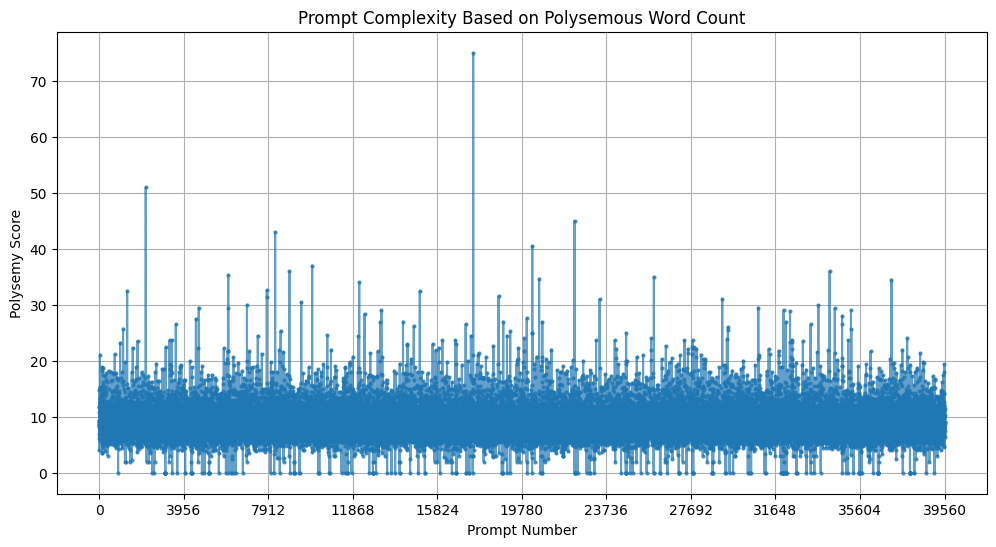

In [57]:
scores = [(index, score) for index, score in enumerate(metrics_res['polysemous'])]
print(f"Total prompts: {len(scores)}")

print_scores = [i[1] for i in scores]

plt.figure(figsize=(12, 6))
plt.plot(range(len(scores)), print_scores, marker='o', linestyle='-', markersize=2, alpha=0.7)
plt.xlabel("Prompt Number")
plt.ylabel("Polysemy Score")
plt.title("Prompt Complexity Based on Polysemous Word Count")
plt.xticks(np.arange(0, len(scores), step=max(1, len(scores)//10)))
plt.grid(True)
plt.show()

In [58]:
print_most_difficult(scores)

17502 2177 22243 
--- 1 example ( 75.0 ):
Break that down.
------

--- 2 example ( 51.0 ):
That makes sense.
------

--- 3 example ( 45.0 ):
give another
------



### Contextual ambiguity

In [ ]:
...

## Grammatical correctness

### Checking errors

In [59]:
!pip install language_tool_python

DEPRECATION: Loading egg at c:\users\user\appdata\local\programs\python\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [ ]:
import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

def compute_grammar_errors(text):
    matches = tool.check(text)
    return len(matches)

grammar_errors = [compute_grammar_errors(text) for text in tqdm(texts, desc="Checking grammar errors")]

scores = list(enumerate(grammar_errors))

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(
    [idx for idx, _ in scores],
    [val for _, val in scores],
    marker='o',
    linestyle='-',
    markersize=2,
    alpha=0.7
)
plt.xlabel("Prompt Number")
plt.ylabel("Number of Grammar Errors")
plt.title("Prompt Grammar Errors Detected")
plt.xticks(np.arange(0, len(scores), step=max(1, len(scores)//10)))
plt.grid(True)
plt.show()

In [ ]:
print_most_difficult(scores)

### Part of speech distribution

In [24]:
def normalize_distribution(counter, total_count):
    return {pos: count / total_count for pos, count in counter.items()} if total_count > 0 else {}


def compute_pos_distribution(text):
    doc = nlp(text)
    pos_counts = Counter(token.pos_ for token in doc if token.is_alpha)
    return normalize_distribution(pos_counts, len([token for token in doc if token.is_alpha]))


pos_distr = [compute_pos_distribution(text) for text in tqdm(texts, desc="Computing POS distribution")]

Computing POS distribution:   0%|          | 0/39564 [00:00<?, ?it/s]

Computing POS distribution: 100%|██████████| 39564/39564 [16:22<00:00, 40.25it/s]  


In [25]:
all_pos_tags = set(tag for dist in pos_distr for tag in dist)
average_distribution = {tag: np.mean([dist.get(tag, 0) for dist in pos_distr]) for tag in all_pos_tags}

In [26]:
def compute_pos_error(dist, avg_dist):
    return sum(abs(dist.get(pos, 0) - avg_dist.get(pos, 0)) for pos in all_pos_tags)


metrics_res['part_of_speech'] = [
    compute_pos_error(dist, average_distribution) for dist in tqdm(pos_distr, "Computing Pos Score")
]

Computing Pos Score: 100%|██████████| 39564/39564 [00:00<00:00, 146715.11it/s]


39564


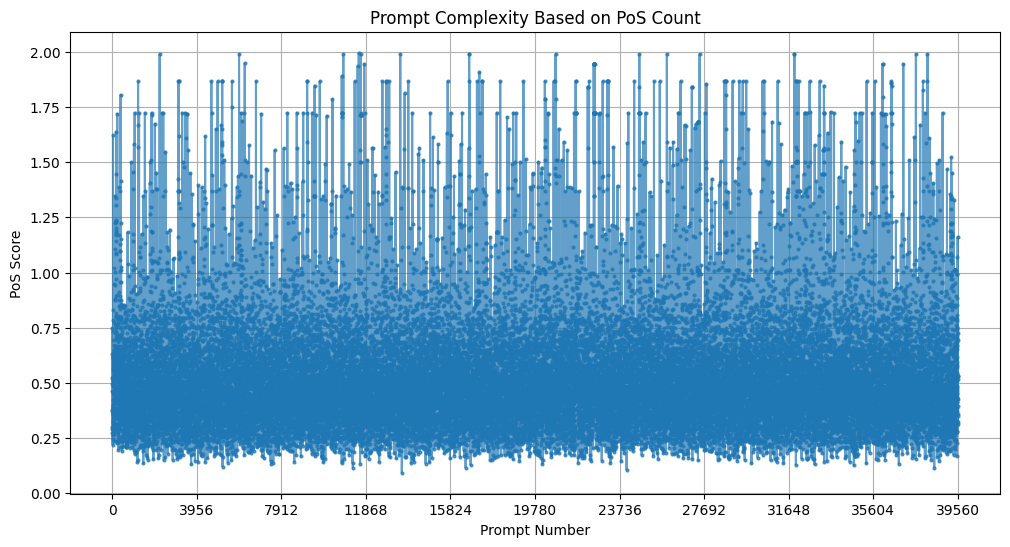

In [57]:
scores = [(index, score) for index, score in enumerate(metrics_res['part_of_speech'])]

print(len(metrics_res['part_of_speech']))

plt.figure(figsize=(12, 6))
plt.plot(range(len(scores)), metrics_res['part_of_speech'], marker='o', linestyle='-', markersize=2, alpha=0.7)
plt.xlabel("Prompt Number")
plt.ylabel("PoS Score")
plt.title("Prompt Complexity Based on PoS Count")
plt.xticks(np.arange(0, len(scores), step=max(1, len(scores)//10)))
plt.grid(True)
plt.show()

In [58]:
print_most_difficult(scores)

11532 2215 5931 10811 11629 
--- 1 example ( 1.9965636663478117 ):
? x 120 = 173 x 240
------

--- 2 example ( 1.9902929015945665 ):
hi
------

--- 3 example ( 1.9902929015945665 ):
ha
------

--- 4 example ( 1.9902929015945665 ):
Yes, please!
------

--- 5 example ( 1.9902929015945665 ):
yes?
------



## Readability score

### Flesch-Kincaid score

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import textstat  

def compute_flesch_kincaid_grade(text):

    try:
        grade = textstat.flesch_kincaid_grade(text)
    except Exception as e:
        grade = 0
    return grade

metrics_res = {}
metrics_res['flesch_kincaid_grade'] = [
    compute_flesch_kincaid_grade(text) for text in tqdm(texts, desc="Computing Flesch-Kincaid Grade")
]


Computing Flesch-Kincaid Grade: 100%|██████████| 39564/39564 [00:12<00:00, 3207.44it/s]


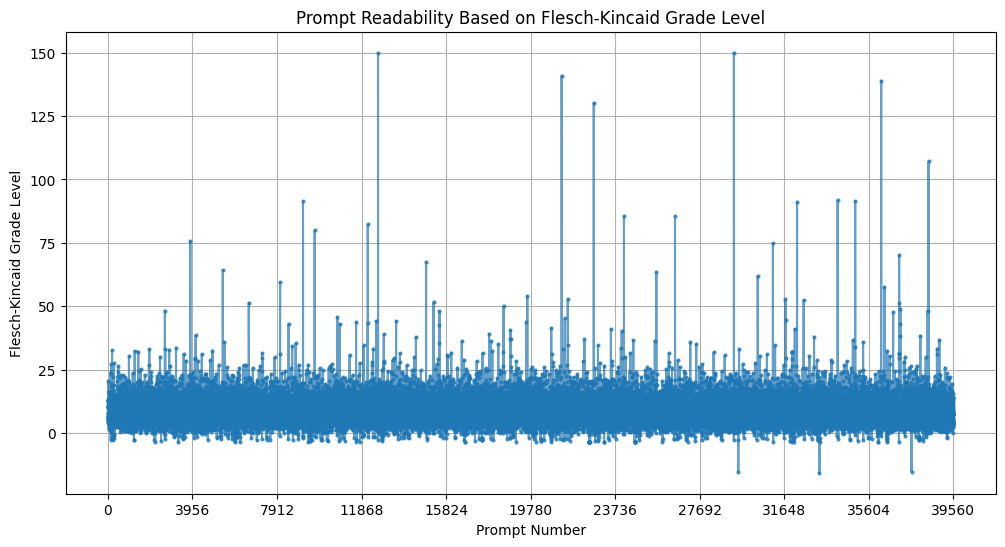

In [14]:
scores_fk = [(index, score) for index, score in enumerate(metrics_res['flesch_kincaid_grade'])]

plt.figure(figsize=(12, 6))
plt.plot(
    range(len(scores_fk)),
    [score for _, score in scores_fk],
    marker='o',
    linestyle='-',
    markersize=2,
    alpha=0.7
)
plt.xlabel("Prompt Number")
plt.ylabel("Flesch-Kincaid Grade Level")
plt.title("Prompt Readability Based on Flesch-Kincaid Grade Level")
plt.xticks(np.arange(0, len(scores_fk), step=max(1, len(scores_fk)//10)))
plt.grid(True)
plt.show()



In [24]:
print_most_difficult(scores_fk, reverse=True, filtered=True)


12639 29292 21230 36185 22734 
--- 1 example ( 150.0 ):
nigganigganigganigganigganigganigganigganigganigganigganigganigga
------

--- 2 example ( 150.0 ):
https://medium.com/@tayyibali4300/implementing-lm-studio-in-crewai-270cc577acee
------

--- 3 example ( 140.9 ):
Determine whether the group G with order 18, defined by the following Cayley table, is isomorphic to the cyclic group C18, the non-abelian group of order 18, or the direct product of a cyclic group of order 3 and a group of order 6:

| G | a | b | c | d | e | f | g | h | i | j | k | l | m | n | o | p | q |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| a | a | b | c | d | e | f | g | h | i | j | k | l | m | n | o | p | q |
| b | b | a | e | f | c | d | j | i | n | m | k | l | h | g | q | p | o |
| c | c | e | a | g | b | k | h | n | i | f | m | p | q | d | j | o | l |
| d | d | f | g | a | h | j | b | o | k | l | n | i | p | c | e | q | m |
| e | e | c | b | h | a | l | n | f | p | q | j | k | 

### Gunning Fog Index

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import textstat  

def compute_gunning_fog_index(text):
    try:
        index = textstat.gunning_fog(text)
    except Exception as e:
        index = 0
    return index

metrics_res['gunning_fog_index'] = [
    compute_gunning_fog_index(text) for text in tqdm(texts, desc="Computing Gunning Fog Index")
]


Computing Gunning Fog Index: 100%|██████████| 39564/39564 [00:06<00:00, 5750.16it/s]


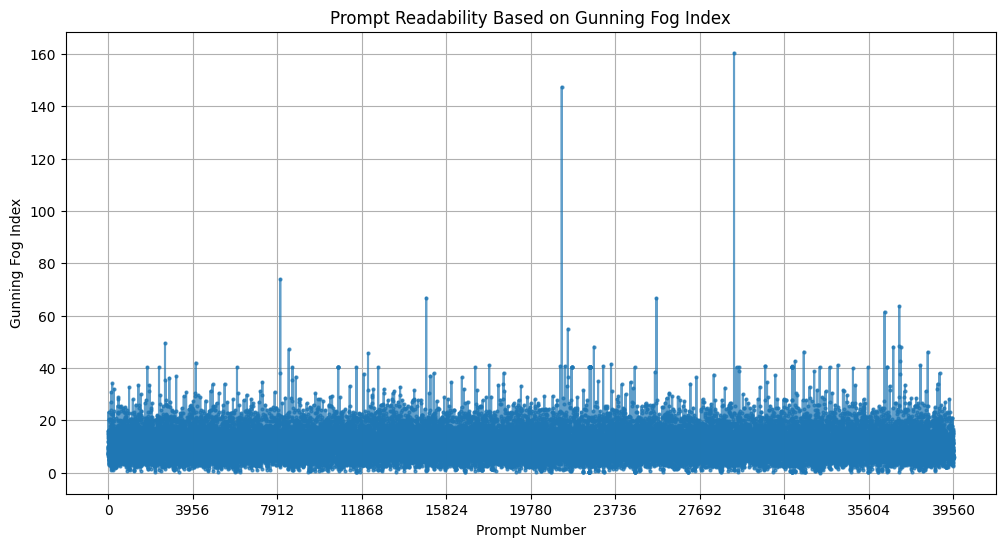

In [26]:

scores_gf = [(index, score) for index, score in enumerate(metrics_res['gunning_fog_index'])]

plt.figure(figsize=(12, 6))
plt.plot(
    range(len(scores_gf)),
    [score for _, score in scores_gf],
    marker='o',
    linestyle='-',
    markersize=2,
    alpha=0.7
)
plt.xlabel("Prompt Number")
plt.ylabel("Gunning Fog Index")
plt.title("Prompt Readability Based on Gunning Fog Index")
plt.xticks(np.arange(0, len(scores_gf), step=max(1, len(scores_gf)//10)))
plt.grid(True)
plt.show()



In [28]:
print_most_difficult(scores_gf)


29292 21230 8057 14888 25664 
--- 1 example ( 160.4 ):
https://medium.com/@tayyibali4300/implementing-lm-studio-in-crewai-270cc577acee
------

--- 2 example ( 147.42 ):
Determine whether the group G with order 18, defined by the following Cayley table, is isomorphic to the cyclic group C18, the non-abelian group of order 18, or the direct product of a cyclic group of order 3 and a group of order 6:

| G | a | b | c | d | e | f | g | h | i | j | k | l | m | n | o | p | q |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| a | a | b | c | d | e | f | g | h | i | j | k | l | m | n | o | p | q |
| b | b | a | e | f | c | d | j | i | n | m | k | l | h | g | q | p | o |
| c | c | e | a | g | b | k | h | n | i | f | m | p | q | d | j | o | l |
| d | d | f | g | a | h | j | b | o | k | l | n | i | p | c | e | q | m |
| e | e | c | b | h | a | l | n | f | p | q | j | k | g | o | i | m | d |
| f | f | d | k | j | l | a | m | p | q | e | o | n | i | h | b | g | c |
| g |

### Dale-Chall Readability Score

In [69]:
!pip install textstat

DEPRECATION: Loading egg at c:\users\user\appdata\local\programs\python\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import textstat  

def compute_dale_chall_readability(text):
    try:
        score = textstat.dale_chall_readability_score(text)
    except Exception as e:
        score = 0
    return score

metrics_res['dale_chall_score'] = [
    compute_dale_chall_readability(text) for text in tqdm(texts, desc="Computing Dale-Chall Readability Score")
]


Computing Dale-Chall Readability Score: 100%|██████████| 39564/39564 [00:06<00:00, 6015.97it/s]


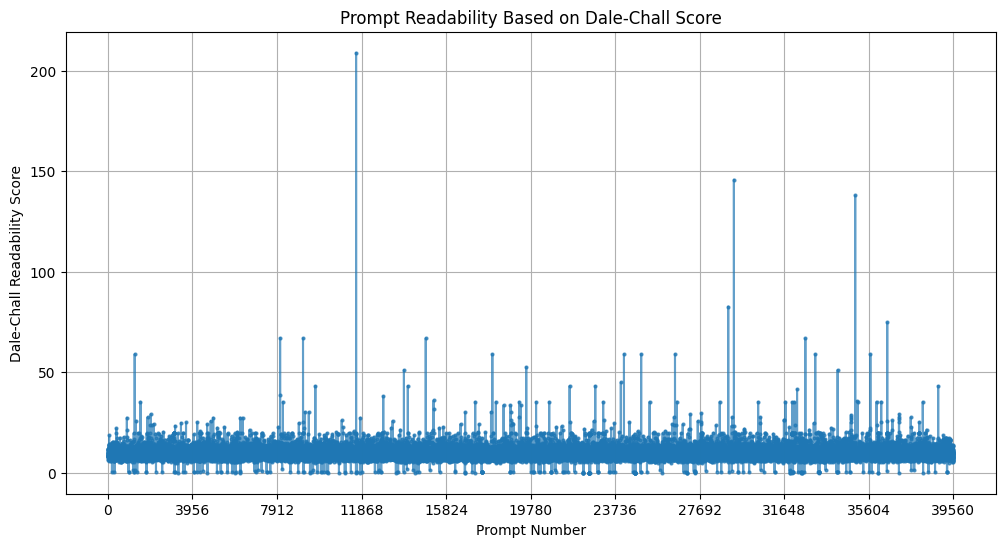

In [30]:
scores_dc = [(index, score) for index, score in enumerate(metrics_res['dale_chall_score'])]

plt.figure(figsize=(12, 6))
plt.plot(
    range(len(scores_dc)),
    [score for _, score in scores_dc],
    marker='o',
    linestyle='-',
    markersize=2,
    alpha=0.7
)
plt.xlabel("Prompt Number")
plt.ylabel("Dale-Chall Readability Score")
plt.title("Prompt Readability Based on Dale-Chall Score")
plt.xticks(np.arange(0, len(scores_dc), step=max(1, len(scores_dc)//10)))
plt.grid(True)
plt.show()


In [33]:


print_most_difficult(scores_dc, reverse=True)


11613 29292 34969 29027 36468 
--- 1 example ( 208.96 ):
https://mt0.google.com/vt/lyrs=s&hl=en&x={x}&y={y}&z={z}
------

--- 2 example ( 145.8 ):
https://medium.com/@tayyibali4300/implementing-lm-studio-in-crewai-270cc577acee
------

--- 3 example ( 137.95 ):
Calculate: $\frac53\times\frac{6}{10}\times\frac{15}{9}\times\frac{12}{20}\times\frac{25}{15}\times\frac{18}{30}\times\frac{35}{21}\times\frac{24}{40}$
------

--- 4 example ( 82.69 ):
Multiply $(2x^3-5y^2)(4x^6+10x^3y^2+25y^4)$.
------

--- 5 example ( 74.79 ):
Simplify $\dfrac{18}{17}\cdot\dfrac{13}{24}\cdot\dfrac{68}{39}$.
------



# Save metrics

In [28]:
import os


folder_name = 'metrics'
file_extension = '.txt'

os.makedirs(folder_name, exist_ok=True)

for field, values in metrics_res.items():
    file_path = os.path.join(folder_name, f"{field}{file_extension}")
    
    with open(file_path, 'w') as f:
        for value in values:
            f.write(f"{value}\n") 

print("Data has been stored successfully")

Data has been stored successfully
